# 2D GRF data Regression with domain-decomposed OpFlow
case1, scatter observations

run ``2D_domain_decomposed_GRF_prior.ipynb`` first

### load necessary libraries

In [2]:
from __future__ import division

from sklearn import cluster, datasets, mixture
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic
import torch
import torch.nn as nn 
from math import pi 
import torch.nn.functional as F
from torch.nn.parameter import Parameter

from torch.distributions.multivariate_normal import MultivariateNormal
import math
from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate
import pylab as plt
import statsmodels.api as sm
#from random_fields import *

import timeit
from matplotlib.colors import TwoSlopeNorm

In [3]:
import os

#os.environ['CUDA_VISIBLE_DEVICES'] = "5"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_num_threads(1)

In [4]:
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor

def GaussianProcess_2C(ndim, length_scale, nu, n_samples, return_kernel=False, nchannel = 1):
    x = np.linspace(0, 1, ndim)
    y = np.linspace(0, 1, ndim)
    XX, YY = np.meshgrid(x, y)
    XX = XX.reshape(-1, 1)
    YY = YY.reshape(-1, 1)
    X = np.concatenate([XX, YY], axis=1)
    print(X.shape)
    kernel = 1.0 * Matern(length_scale=length_scale, length_scale_bounds=(1e-1, 10.0), nu=nu)
    gpr_model = GaussianProcessRegressor(kernel=kernel)
    y_mean, y_std = gpr_model.predict(X, return_std=True)
    if nchannel == 1:
        y_samples = gpr_model.sample_y(X, n_samples)[:,:,np.newaxis]
    else:
        arr = []
        a = gpr_model.sample_y(X, n_samples*nchannel)[:,:,None]
        for i in range(nchannel):
            arr.append(a[:,n_samples*i:n_samples*(i+1),:])
        y_samples = np.concatenate(arr, axis=-1)
        assert(y_samples.shape == np.zeros([ndim*ndim, n_samples, nchannel]).shape)
        
    if return_kernel:
        return torch.tensor(y_samples), kernel(X), gpr_model
    else:
        return torch.tensor(y_samples)
    
def compute_acovf(z):
    # z shape : [n, ndim, ndim]
    res = z.shape[-1]
    z_hat = torch.fft.rfft2(z)
    acf = torch.fft.irfft2(torch.conj(z_hat) * z_hat)
    acf = torch.fft.fftshift(acf).mean(dim=0) / z[0].numel() # ndim*ndim
    acf_r = acf.view(-1).cpu().detach().numpy()
    lags_x, lags_y = torch.meshgrid(torch.arange(res) - res//2, torch.arange(res) - res//2)
    lags_r = torch.sqrt(lags_x**2 + lags_y**2).view(-1).cpu().detach().numpy()

    idx = np.argsort(lags_r)
    lags_r = lags_r[idx]
    acf_r = acf_r[idx]

    bin_means, bin_edges, binnumber = binned_statistic(lags_r, acf_r, 'mean', bins=np.linspace(0.0, res, 50))
    return bin_edges[:-1], bin_means

### dataset parameters and preparation

In [5]:
ntrain = 20000
nchannel = 1
ndim = 32
batch_size = 256

length_scale_x = 0.5
nu_x = 1.5

length_scale_z = 0.1
nu_z = 0.5



Starting up. Generate GRF samples
(1024, 2)
(1024, 2)


/home/yshi5/miniconda3/envs/Pytorch/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755849709/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


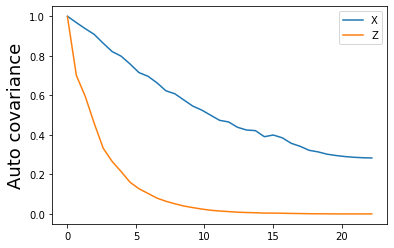

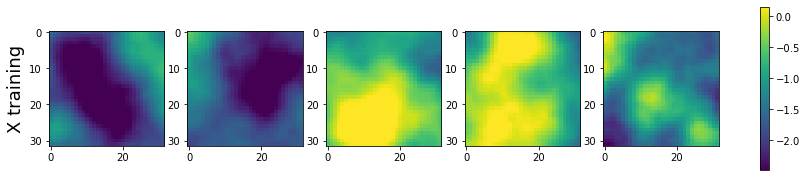

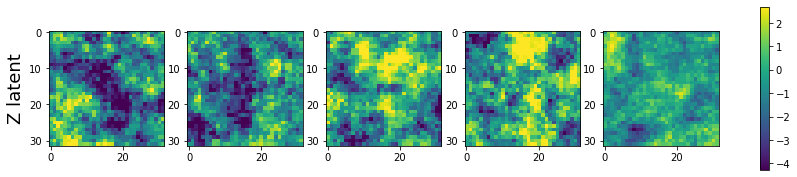

In [6]:
print("Starting up. Generate GRF samples")
import statsmodels.api as sm

np.random.seed(22)

x_train = GaussianProcess_2C(ndim, length_scale_x, nu_x, ntrain, return_kernel=False, nchannel=nchannel)
x_train = x_train.float().permute([1,0,2]).reshape(-1, ndim, ndim, nchannel)
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train), batch_size=batch_size, shuffle=True,pin_memory=False)

## calculate the autocov 
z_train, kernel, z_gpmodel = GaussianProcess_2C(ndim, length_scale_z, nu_z, 2*ntrain, return_kernel=True, nchannel=nchannel)
z_train = z_train.float().permute([1,0,2]).reshape(-1, ndim, ndim, nchannel)
z_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(z_train), batch_size=batch_size, shuffle=True,pin_memory=False)

## calculate the statistics 
x_distance, x_acovf_mean = compute_acovf(x_train[:,:,:,0])
z_distance, z_acovf_mean = compute_acovf(z_train[:,:,:,0])

plt.plot(x_distance, x_acovf_mean, label='X')
plt.plot(z_distance, z_acovf_mean, label='Z')
plt.legend()
plt.ylabel("Auto covariance", fontsize=18)

fig, ax = plt.subplots(1,5, figsize=(15,3))
for i in range(5):
    x = x_train[i,:,:,0].squeeze()
    ax[i].imshow(x, vmin=-2, vmax=2)
    if i == 0:
        ax[i].set_ylabel('X training', fontsize=18)

#cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
bar = ax[4].imshow(x)
fig.colorbar(bar, ax=ax)
#plt.show()

fig, ax = plt.subplots(1,5, figsize=(15,3))    
for i in range(5):
    z = z_train[i,:,:,0].squeeze()
    ax[i].imshow(z, vmin=-2, vmax=2)
    if i == 0:
        ax[i].set_ylabel('Z latent', fontsize=18)
              
bar = ax[4].imshow(z)
fig.colorbar(bar, ax=ax)

# load dataset

In [7]:
def kernel_loc(in_chan=2, up_dim=32):
    """
        Kernel network apply on grid
    """
    layers = nn.Sequential(
                nn.Linear(in_chan, up_dim, bias=True), torch.nn.GELU(),
                nn.Linear(up_dim, up_dim, bias=True), torch.nn.GELU(),
                nn.Linear(up_dim, 1, bias=False)
            )
    return layers

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, dim1, dim2,modes1 = None, modes2 = None):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """
        in_channels = int(in_channels)
        out_channels = int(out_channels)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dim1 = dim1 #output dimensions
        self.dim2 = dim2
        if modes1 is not None:
            self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
            self.modes2 = modes2
        else:
            self.modes1 = dim1//2-1 #if not given take the highest number of modes can be taken
            self.modes2 = dim2//2 
        self.scale = (1 / (2*in_channels))**(1.0/2.0)
        self.weights1 = nn.Parameter(self.scale * (torch.randn(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)))
        self.weights2 = nn.Parameter(self.scale * (torch.randn(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat)))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x, dim1 = None,dim2 = None):
        if dim1 is not None:
            self.dim1 = dim1
            self.dim2 = dim2
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1 , dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft)
        #x = torch.fft.irfft2(out_ft, s=(self.dim1, self.dim2))
        return x



class pointwise_op(nn.Module):
    def __init__(self, in_channel, out_channel,dim1, dim2):
        super(pointwise_op,self).__init__()
        self.conv = nn.Conv2d(int(in_channel), int(out_channel), 1)
        self.dim1 = int(dim1)
        self.dim2 = int(dim2)

    def forward(self,x, dim1 = None, dim2 = None):
        if dim1 is None:
            dim1 = self.dim1
            dim2 = self.dim2
        x_out = self.conv(x)
        #x_out = torch.nn.functional.interpolate(x_out, size = (dim1, dim2),mode = 'bicubic',align_corners=True)
        return x_out

In [8]:
class FNO2d(nn.Module):
    def __init__(self, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        #self.modes1 = modes1
        #self.modes2 = modes2
        self.width = width
        self.padding = 0 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)
        
        self.conv0 = SpectralConv2d(self.width, self.width, 32, 32, 16, 16)

        self.conv1 = SpectralConv2d(self.width, self.width, 32, 32, 16, 16)
        
        self.conv2 = SpectralConv2d(self.width, self.width, 32, 32, 16, 16)

        self.conv3 = SpectralConv2d(self.width, self.width, 32, 32, 16, 16)
        
        self.w0 = pointwise_op(self.width, self.width, 32, 32) #
        
        self.w1 = pointwise_op(self.width, self.width, 32, 32) #
        
        self.w2 = pointwise_op(self.width, self.width, 32, 32) #
        
        self.w3 = pointwise_op(self.width, self.width, 32, 32) #
        
        self.fc1 = nn.Linear(self.width, 2*self.width)
        # first three are normalized 3C waveforms, last three are associated PGAs
        self.fc2 = nn.Linear(2*self.width, 2) # s and t


    def forward(self, x):
        res1 = x.shape[1]
        res2 = x.shape[2]
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
         
        x_fc0 = self.fc0(x)
        x_fc0 = F.gelu(x_fc0)
        
        x_fc0 = x_fc0.permute(0, 3, 1, 2)
        #x_fc0 = F.pad(x_fc0, [0,self.padding, 0,self.padding])
        
        x1 = self.conv0(x_fc0)
        x2 = self.w0(x_fc0)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)
        
        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        x = F.gelu(x)
        x = x.permute(0, 2, 3, 1)

        x_fc1 = self.fc1(x)
        x_fc1 = F.gelu(x_fc1)

        x_out = self.fc2(x_fc1)

        return x_out
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [9]:
class ActNorm(nn.Module):
    def __init__(self, in_channel, logdet=True):
        super().__init__()
        
        self.loc = nn.Parameter(torch.zeros(1, 1, 1, in_channel))
        self.log_scale = nn.Parameter(torch.zeros(1, 1, 1, in_channel))

        self.register_buffer("initialized", torch.tensor(0, dtype=torch.uint8))
        self.logdet = logdet

    def initialize(self, input):
        with torch.no_grad():
            #flatten = input.permute(1, 0, 2).contiguous().view(input.shape[1], -1)
            mean = input.mean(dim=(0,1,2)).unsqueeze(0).unsqueeze(1).unsqueeze(2)
            std = input.std(dim=(0,1,2)).unsqueeze(0).unsqueeze(1).unsqueeze(2)

            self.loc.data.copy_(-mean)
            self.log_scale.data.copy_(torch.log(1 / (std + 1e-6)))

    def forward(self, input):
        batch_size, ndim1, ndim2, _ = input.shape

        if self.initialized.item() == 0:
            self.initialize(input)
            self.initialized.fill_(1)
            
        scale = torch.exp(self.log_scale)
        output = scale * (input + self.loc)        

        logdet = batch_size * ndim1 * ndim2 * self.log_scale.sum() #pointwise operation
        
        return output, logdet


    def inverse(self, output):
        #_, length, wdith, _ = output.shape
        scale = torch.exp(self.log_scale)
        output = output / scale - self.loc
        #logdet = -1.0 * width * length * self.log_scale.sum()
        
        #return output, logdet
        return output

In [10]:
class AffineCoupling(nn.Module):
    def __init__(self, width, block_dim):
        super(AffineCoupling, self).__init__()
        """
        A single affine coupling operator block
        This layer splits the input spatially and computes scale and shift functions
        It consists of two FNO networks to compute scale and shift functions
        The scale and shift functions are then used to transform the other
        half of the input function
        """
        self.width = width
        self.coupling = FNO2d(width)
        self.k = block_dim
        self.actnorm = ActNorm(1)

    def forward(self, z, flip=False):
        x = z
        x, log_actnorm = self.actnorm(x)
        n_rep = x.shape[2] // (2*self.k) + 1
        mask_a = torch.eye(2, device=x.device).bool()
        mask_a = mask_a.repeat_interleave(self.k, dim=1).repeat_interleave(self.k, dim=0).tile(n_rep, n_rep)

        mask_a = mask_a[:x.shape[1], :x.shape[2]]
        mask_b = torch.logical_not(mask_a)

        x1 = x * mask_a[None,:,:,None]
        x2 = x * mask_b[None,:,:,None]
        
        if flip:
            x2, x1 = x1, x2
            mask_b, mask_a = mask_a, mask_b

        # forward
        #print("x1. shape:{}".format(x1.shape))
        scale_shift = self.coupling(x1)
        #print("scale_shift shape:{}".format(scale_shift.shape))
        log_scale = scale_shift[:,:,:,0].unsqueeze(3)
        scale = torch.exp(log_scale)
        shift = scale_shift[:,:,:,1].unsqueeze(3)
        z1 = x1
        z2 = x2 * scale + shift

        z_hat = z1 + mask_b[None,:,:,None] * z2
        log_det = (log_scale * mask_b[None,:,:,None]).sum()
        log_det = log_det + log_actnorm
        
        return z_hat, log_det

    def inverse(self, z, flip=False):
        n_rep = z.shape[2] // (2*self.k) + 1
        mask_a = torch.eye(2, device=z.device).bool()
        mask_a = mask_a.repeat_interleave(self.k, dim=1).repeat_interleave(self.k, dim=0).tile(n_rep, n_rep)
        mask_a = mask_a[:z.shape[2], :z.shape[2]]
        mask_b = torch.logical_not(mask_a)
        z1 = z * mask_a[None,:,:,None]
        z2 = z * mask_b[None,:,:,None]

        if flip:
            z2, z1 = z1, z2
            mask_b, mask_a = mask_a, mask_b
            
        x1 = z1
        scale_shift = self.coupling(z1)
        log_scale = scale_shift[:,:,:,0].unsqueeze(3)
        scale = torch.exp(-log_scale)
        shift = scale_shift[:,:,:,1].unsqueeze(3)
        x2 = (z2 - shift) * scale
            
        x_hat = x1 + mask_b[None,:,:,None] * x2
        x_hat = self.actnorm.inverse(x_hat)
        
        return x_hat

In [11]:
class OpFlow(nn.Module):
    def __init__(self, width, blocks, block_base_dim, base_dist, pool_every=2, kernel=None, gp=None):
        super().__init__()
        self.flips = [True if i%2 else False for i in range(blocks)]
        block_dims = []
        block_dim = block_base_dim
        block_dims = block_base_dim

        self.bijectors = nn.ModuleList([
            AffineCoupling(width=width, block_dim=block_dims[i]) for i in range(blocks)
        ])
        if kernel is not None:
            self.kernel = kernel
        if gp is not None:
            self.gp = gp
        self.base_dist = base_dist
        
    def forward(self, x):
        batch_size = x.shape[0]
        log_dets = []

        for bijector, f in zip(self.bijectors, self.flips):
            x, log_det = bijector(x, flip=f)
            log_dets.append(log_det)
        z = x
        log_pz = self.base_dist.log_prob(z.reshape(x.shape[0], -1)).sum()
        
        return x, log_pz/batch_size, sum(log_dets)/batch_size
    
    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z

In [12]:
lr = 1e-4
epochs = 200 
reg_fac = 1

n_train_tot = int(ntrain/batch_size)

block_base_dim = [16, 16, 8, 8, 4, 4, 2, 2, 1, 1]
#block_base_dim = [32, 32, 16, 16, 8, 8, 4, 4]
modes = ndim // 4
width = 32
blocks = len(block_base_dim)
base_mu = torch.zeros(ndim*ndim).float()
base_cov = torch.tensor(kernel).float()
base_dist = torch.distributions.MultivariateNormal(base_mu.to(device), scale_tril=torch.linalg.cholesky_ex(base_cov)[0].to(device))

# Model Trainig

In [12]:
G = OpFlow(width=width, blocks=blocks, block_base_dim=block_base_dim, base_dist=base_dist).to(device)

folder = "GRF2GRF_FNO_domain_decomposed_32x32_prior"
model_path = f"paper_saved_models/{folder}/2D_domain_decomposed_249_prior.pt"
    
checkpoint = torch.load(model_path, map_location='cpu')
G.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [13]:
model= G

### check other statistical


In [14]:
x_hist_true, bin_edges = x_train.histogram(range=[-5.5,5.5], density=True)
x_pos = x_distance/ndim

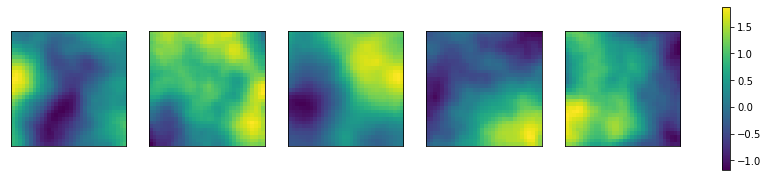

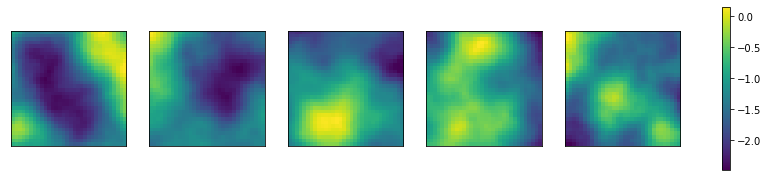

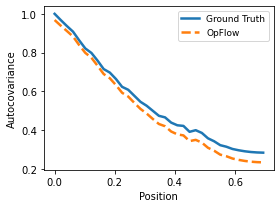

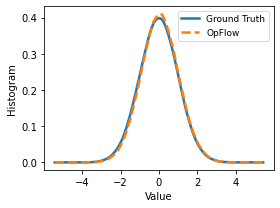

In [15]:
with torch.no_grad():
    Z = base_dist.rsample(sample_shape=(5,)).reshape(-1,ndim,ndim,1)
    X_hat = model.inverse(Z).detach().cpu().numpy()
    
    X_ground_truth = x_train[:5]
    Z_alt = base_dist.rsample(sample_shape=(5000,)).reshape(-1,ndim,ndim,1)

    z_train_iter = torch.split(Z_alt, 1000, dim=0)
    X_alt = []
    for i in range(len(z_train_iter)):
        z_train_temp = z_train_iter[i].to(device)
        x_alt = model.inverse(z_train_temp).detach().cpu()
        X_alt.append(x_alt)
        
    X_alt = torch.vstack(X_alt)        
    _, x_acovf = compute_acovf(X_alt.squeeze())
    _, x_acovf_true = compute_acovf(x_train.squeeze())
    x_hist, bin_edges_alt = X_alt.histogram(range=[-5.5,5.5], density=True)

    fig, ax = plt.subplots(1,5, figsize=(15,3))
    for i in range(5):
        x = X_hat[i,:,:].squeeze()

        ax[i].imshow(x)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        #if i == 0:
            #ax[i].set_ylabel('OpFlow', fontsize=16)
        #ax[0].plot(x_ground_truth)
        #ax[0].set_title('Real')
        #ax[1].plot(x)
        #ax[1].set_title('OpFlow Generated')
        #ax[0].set_ylim([-3, 3])
        #ax[1].plot(sm.tsa.acovf(x, nlag=50))
        #ax[1].set_ylim([0.0, 1.0])

    #cb = fig.colorbar(ax[4].imshow(), , orientation='vertical')
    bar = ax[4].imshow(x)
    fig.colorbar(bar, ax=ax)

    #plt.show()
    #plt.savefig(f"paper_pdf/{folder}/{folder}_opflow_samples.pdf")

    # covariance use position as x, adjust the size of histogram

    fig, ax = plt.subplots(1,5, figsize=(15,3))    
    for i in range(5):
        x_ground_truth = X_ground_truth[i,:,:].squeeze()
        ax[i].imshow(x_ground_truth)
        ax[i].set_xticks([])
        ax[i].set_yticks([])

    bar = ax[4].imshow(x_ground_truth)
    fig.colorbar(bar, ax=ax)
    #plt.savefig(f"paper_pdf/{folder}/{folder}_ground_truth.pdf")


    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot(x_pos, x_acovf_true, c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot(x_pos, x_acovf,c='#ff7f0e', ls='--', lw=2.5, label='OpFlow')
    #ax[0].set_ylim(0,1.1)
    ax.set_ylabel('Autocovariance')
    ax.set_xlabel('Position')
    ax.legend(loc='upper right', fontsize=9)
    plt.tight_layout()
    #plt.savefig(f"paper_pdf/{folder}/{folder}_autocov.pdf")
    
    
    fig, ax = plt.subplots(1, 1, figsize=(4,3))
    ax.plot((bin_edges[1:]+bin_edges[:-1])/2, x_hist_true,  c='#1f77b4', lw=2.5, label='Ground Truth')
    ax.plot((bin_edges_alt[1:]+bin_edges_alt[:-1])/2, x_hist, c='#ff7f0e', lw=2.5, ls='--',  label='OpFlow')
    ax.set_ylabel('Histogram')
    ax.set_xlabel('Value')
    ax.legend(loc='upper right', fontsize=9)
    plt.tight_layout()
    #plt.savefig(f"paper_pdf/{folder}/{folder}_statistic.pdf")


## 2D Regression (scatter observations)

In [ ]:
from sklearn.gaussian_process.kernels import WhiteKernel

for param in G.parameters():
    param.requires_grad = False

In [13]:
ndim = 32
lr = 1e-3 
epochs = 5000
noise_level = 0.01

# create new 
berno_mask = torch.zeros((ndim, ndim))
mask_idx = np.random.choice(ndim*ndim, 32,replace=False)

#mask_idx = np.array([901, 863, 331, 436, 145, 866, 857, 195, 912, 817, 651, 408, 128, 704, 737, 138, 911, 
#574, 810, 641, 313, 197, 462, 727, 847, 682, 449, 1017, 503, 469, 44, 763]) #mask_idx used for the paper
berno_mask.reshape(-1)[mask_idx] = 1

berno_mask = berno_mask.reshape(32,32)
pos_mask = (berno_mask == 1)

u_obs_full = x_train[0:1,:,  :,0:1]
u_obs_part = u_obs_full[:,pos_mask,:].to(device)
u_obs_full = u_obs_full.squeeze()

mask_idx
array([ 901,  863,  331,  436,  145,  866,  857,  195,  912,  817,  651,
        408,  128,  704,  737,  138,  911,  574,  810,  641,  313,  197,
        462,  727,  847,  682,  449, 1017,  503,  469,   44,  763])

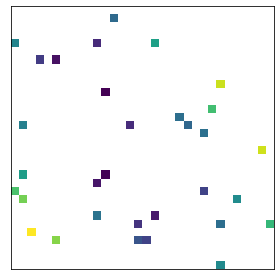

In [14]:
part_gt = u_obs_full.clone()
part_gt[~pos_mask] = np.nan
# plot the partial observation 
plt.imshow(part_gt)

plt.xticks([])
plt.yticks([])
#plt.title('Partial Observation', fontsize=16)
plt.tight_layout()

#plt.savefig('./demo_figure.png', transparent=True)
plt.show()

## Get MAP for a

In [124]:
class regression_opflow_a(nn.Module):
    def __init__(self, G):
        super().__init__()
        self.G = G
        self.a_target = nn.Parameter(torch.zeros(1,ndim, ndim, 1))
                                       
    def initialize(self, input):
        self.a_target.data = input.to(device)
        
    def target_u(self):
        return self.G.inverse(self.a_target)
        
    def logp(self):
        u = self.target_u()
        a, log_pa, log_det = self.G(u)
        return log_pa+log_det

    
def reg_process_a(reg_opflw_a, reg_optim_a, epochs, reg_scheduler=None):
    losses = np.zeros(epochs)
    for epoch in range(epochs):
        # maximize a posterior 
        reg_optim_a.zero_grad()
        loss1 = -0.5*torch.sum((u_obs_part - reg_opflow_a.target_u()[:,pos_mask,:])**2)/noise_level
        #loss1 = -0.5*torch.sum((u_obs_part - reg_opflow_u.u_target[:,pos_mask,:])**2)/noise_level
        loss2 = reg_opflow_a.logp()
        loss = -(loss1 + loss2)
        loss.backward()
        reg_optim_a.step()
        losses[epoch] = loss.item()
        if reg_scheduler is not None:
            reg_scheduler.step()
        print("epcoh:{}, loss:{}".format(epoch, loss.item()))
    return losses


In [125]:
reg_opflow_a = regression_opflow_a(G).to(device)
reg_optim_a = torch.optim.Adam(reg_opflow_a.parameters(), lr=lr , weight_decay=1e-4)

In [126]:
losses = reg_process_a(reg_opflow_a, reg_optim_a, epochs)

epcoh:0, loss:364.828125
epcoh:1, loss:350.118408203125
epcoh:2, loss:335.4580078125
epcoh:3, loss:320.854736328125
epcoh:4, loss:306.3134765625
epcoh:5, loss:291.823486328125
epcoh:6, loss:277.40087890625
epcoh:7, loss:263.031982421875
epcoh:8, loss:248.731201171875
epcoh:9, loss:234.481689453125
epcoh:10, loss:220.30126953125
epcoh:11, loss:206.18408203125
epcoh:12, loss:192.128173828125
epcoh:13, loss:178.135986328125
epcoh:14, loss:164.211181640625
epcoh:15, loss:150.35205078125
epcoh:16, loss:136.554443359375
epcoh:17, loss:122.82666015625
epcoh:18, loss:109.16748046875
epcoh:19, loss:95.5732421875
epcoh:20, loss:82.045166015625
epcoh:21, loss:68.5869140625
epcoh:22, loss:55.19482421875
epcoh:23, loss:41.875244140625
epcoh:24, loss:28.623291015625
epcoh:25, loss:15.439697265625
epcoh:26, loss:2.322509765625
epcoh:27, loss:-10.7236328125
epcoh:28, loss:-23.695556640625
epcoh:29, loss:-36.6015625
epcoh:30, loss:-49.43798828125
epcoh:31, loss:-62.209228515625
epcoh:32, loss:-74.90698

epcoh:245, loss:-1602.3486328125
epcoh:246, loss:-1605.8343505859375
epcoh:247, loss:-1609.2984619140625
epcoh:248, loss:-1612.74169921875
epcoh:249, loss:-1616.1632080078125
epcoh:250, loss:-1619.5660400390625
epcoh:251, loss:-1622.9486083984375
epcoh:252, loss:-1626.31103515625
epcoh:253, loss:-1629.6524658203125
epcoh:254, loss:-1632.9754638671875
epcoh:255, loss:-1636.279296875
epcoh:256, loss:-1639.5626220703125
epcoh:257, loss:-1642.828857421875
epcoh:258, loss:-1646.0714111328125
epcoh:259, loss:-1649.297607421875
epcoh:260, loss:-1652.5057373046875
epcoh:261, loss:-1655.69384765625
epcoh:262, loss:-1658.8642578125
epcoh:263, loss:-1662.0162353515625
epcoh:264, loss:-1665.1495361328125
epcoh:265, loss:-1668.262939453125
epcoh:266, loss:-1671.35986328125
epcoh:267, loss:-1674.439208984375
epcoh:268, loss:-1677.5003662109375
epcoh:269, loss:-1680.54345703125
epcoh:270, loss:-1683.5684814453125
epcoh:271, loss:-1686.57568359375
epcoh:272, loss:-1689.56787109375
epcoh:273, loss:-169

epcoh:484, loss:-2077.81298828125
epcoh:485, loss:-2078.95263671875
epcoh:486, loss:-2080.088623046875
epcoh:487, loss:-2081.2216796875
epcoh:488, loss:-2082.35009765625
epcoh:489, loss:-2083.4755859375
epcoh:490, loss:-2084.59716796875
epcoh:491, loss:-2085.715087890625
epcoh:492, loss:-2086.830078125
epcoh:493, loss:-2087.940673828125
epcoh:494, loss:-2089.048583984375
epcoh:495, loss:-2090.152099609375
epcoh:496, loss:-2091.252685546875
epcoh:497, loss:-2092.349609375
epcoh:498, loss:-2093.44287109375
epcoh:499, loss:-2094.533935546875
epcoh:500, loss:-2095.62060546875
epcoh:501, loss:-2096.7041015625
epcoh:502, loss:-2097.7841796875
epcoh:503, loss:-2098.861572265625
epcoh:504, loss:-2099.9345703125
epcoh:505, loss:-2101.00439453125
epcoh:506, loss:-2102.07177734375
epcoh:507, loss:-2103.1357421875
epcoh:508, loss:-2104.19580078125
epcoh:509, loss:-2105.2529296875
epcoh:510, loss:-2106.3076171875
epcoh:511, loss:-2107.358642578125
epcoh:512, loss:-2108.40625
epcoh:513, loss:-2109.4

epcoh:726, loss:-2280.757080078125
epcoh:727, loss:-2281.384521484375
epcoh:728, loss:-2282.01123046875
epcoh:729, loss:-2282.635986328125
epcoh:730, loss:-2283.259765625
epcoh:731, loss:-2283.882568359375
epcoh:732, loss:-2284.503173828125
epcoh:733, loss:-2285.12353515625
epcoh:734, loss:-2285.741943359375
epcoh:735, loss:-2286.359375
epcoh:736, loss:-2286.97607421875
epcoh:737, loss:-2287.591552734375
epcoh:738, loss:-2288.20556640625
epcoh:739, loss:-2288.818359375
epcoh:740, loss:-2289.4296875
epcoh:741, loss:-2290.03955078125
epcoh:742, loss:-2290.64892578125
epcoh:743, loss:-2291.2568359375
epcoh:744, loss:-2291.864013671875
epcoh:745, loss:-2292.4697265625
epcoh:746, loss:-2293.074462890625
epcoh:747, loss:-2293.677734375
epcoh:748, loss:-2294.27978515625
epcoh:749, loss:-2294.88037109375
epcoh:750, loss:-2295.47998046875
epcoh:751, loss:-2296.078857421875
epcoh:752, loss:-2296.675537109375
epcoh:753, loss:-2297.271728515625
epcoh:754, loss:-2297.8671875
epcoh:755, loss:-2298.4

epcoh:969, loss:-2403.658447265625
epcoh:970, loss:-2404.064208984375
epcoh:971, loss:-2404.47021484375
epcoh:972, loss:-2404.876220703125
epcoh:973, loss:-2405.280517578125
epcoh:974, loss:-2405.6845703125
epcoh:975, loss:-2406.08740234375
epcoh:976, loss:-2406.490234375
epcoh:977, loss:-2406.891845703125
epcoh:978, loss:-2407.293701171875
epcoh:979, loss:-2407.694091796875
epcoh:980, loss:-2408.093994140625
epcoh:981, loss:-2408.493408203125
epcoh:982, loss:-2408.892333984375
epcoh:983, loss:-2409.290283203125
epcoh:984, loss:-2409.687255859375
epcoh:985, loss:-2410.08447265625
epcoh:986, loss:-2410.48046875
epcoh:987, loss:-2410.8759765625
epcoh:988, loss:-2411.271484375
epcoh:989, loss:-2411.6650390625
epcoh:990, loss:-2412.05908203125
epcoh:991, loss:-2412.45263671875
epcoh:992, loss:-2412.8447265625
epcoh:993, loss:-2413.23681640625
epcoh:994, loss:-2413.627685546875
epcoh:995, loss:-2414.017333984375
epcoh:996, loss:-2414.408203125
epcoh:997, loss:-2414.79736328125
epcoh:998, lo

epcoh:1204, loss:-2483.823974609375
epcoh:1205, loss:-2484.109130859375
epcoh:1206, loss:-2484.394287109375
epcoh:1207, loss:-2484.678466796875
epcoh:1208, loss:-2484.962646484375
epcoh:1209, loss:-2485.246337890625
epcoh:1210, loss:-2485.529052734375
epcoh:1211, loss:-2485.81201171875
epcoh:1212, loss:-2486.094482421875
epcoh:1213, loss:-2486.37646484375
epcoh:1214, loss:-2486.65771484375
epcoh:1215, loss:-2486.939208984375
epcoh:1216, loss:-2487.22021484375
epcoh:1217, loss:-2487.50048828125
epcoh:1218, loss:-2487.7802734375
epcoh:1219, loss:-2488.0595703125
epcoh:1220, loss:-2488.33935546875
epcoh:1221, loss:-2488.61767578125
epcoh:1222, loss:-2488.896728515625
epcoh:1223, loss:-2489.174560546875
epcoh:1224, loss:-2489.45263671875
epcoh:1225, loss:-2489.729736328125
epcoh:1226, loss:-2490.006591796875
epcoh:1227, loss:-2490.283203125
epcoh:1228, loss:-2490.558837890625
epcoh:1229, loss:-2490.834716796875
epcoh:1230, loss:-2491.1103515625
epcoh:1231, loss:-2491.385498046875
epcoh:123

epcoh:1438, loss:-2540.982666015625
epcoh:1439, loss:-2541.19091796875
epcoh:1440, loss:-2541.398681640625
epcoh:1441, loss:-2541.606201171875
epcoh:1442, loss:-2541.8134765625
epcoh:1443, loss:-2542.02099609375
epcoh:1444, loss:-2542.2275390625
epcoh:1445, loss:-2542.43408203125
epcoh:1446, loss:-2542.639892578125
epcoh:1447, loss:-2542.846435546875
epcoh:1448, loss:-2543.052001953125
epcoh:1449, loss:-2543.25732421875
epcoh:1450, loss:-2543.463134765625
epcoh:1451, loss:-2543.66748046875
epcoh:1452, loss:-2543.87255859375
epcoh:1453, loss:-2544.0771484375
epcoh:1454, loss:-2544.281005859375
epcoh:1455, loss:-2544.485595703125
epcoh:1456, loss:-2544.68896484375
epcoh:1457, loss:-2544.89208984375
epcoh:1458, loss:-2545.094970703125
epcoh:1459, loss:-2545.298095703125
epcoh:1460, loss:-2545.50048828125
epcoh:1461, loss:-2545.70361328125
epcoh:1462, loss:-2545.9052734375
epcoh:1463, loss:-2546.10693359375
epcoh:1464, loss:-2546.30859375
epcoh:1465, loss:-2546.509521484375
epcoh:1466, los

epcoh:1673, loss:-2583.27685546875
epcoh:1674, loss:-2583.431640625
epcoh:1675, loss:-2583.585205078125
epcoh:1676, loss:-2583.739990234375
epcoh:1677, loss:-2583.8935546875
epcoh:1678, loss:-2584.046875
epcoh:1679, loss:-2584.20068359375
epcoh:1680, loss:-2584.3544921875
epcoh:1681, loss:-2584.507080078125
epcoh:1682, loss:-2584.66064453125
epcoh:1683, loss:-2584.81298828125
epcoh:1684, loss:-2584.9658203125
epcoh:1685, loss:-2585.117919921875
epcoh:1686, loss:-2585.270263671875
epcoh:1687, loss:-2585.42236328125
epcoh:1688, loss:-2585.57373046875
epcoh:1689, loss:-2585.725830078125
epcoh:1690, loss:-2585.876953125
epcoh:1691, loss:-2586.028564453125
epcoh:1692, loss:-2586.179443359375
epcoh:1693, loss:-2586.330322265625
epcoh:1694, loss:-2586.480712890625
epcoh:1695, loss:-2586.631591796875
epcoh:1696, loss:-2586.781982421875
epcoh:1697, loss:-2586.93212890625
epcoh:1698, loss:-2587.081787109375
epcoh:1699, loss:-2587.23193359375
epcoh:1700, loss:-2587.381103515625
epcoh:1701, loss:-

epcoh:1909, loss:-2614.860595703125
epcoh:1910, loss:-2614.975341796875
epcoh:1911, loss:-2615.090576171875
epcoh:1912, loss:-2615.204833984375
epcoh:1913, loss:-2615.319091796875
epcoh:1914, loss:-2615.433837890625
epcoh:1915, loss:-2615.5478515625
epcoh:1916, loss:-2615.66162109375
epcoh:1917, loss:-2615.775634765625
epcoh:1918, loss:-2615.8896484375
epcoh:1919, loss:-2616.003173828125
epcoh:1920, loss:-2616.116455078125
epcoh:1921, loss:-2616.229736328125
epcoh:1922, loss:-2616.34326171875
epcoh:1923, loss:-2616.456298828125
epcoh:1924, loss:-2616.569091796875
epcoh:1925, loss:-2616.681640625
epcoh:1926, loss:-2616.79443359375
epcoh:1927, loss:-2616.90673828125
epcoh:1928, loss:-2617.019287109375
epcoh:1929, loss:-2617.13134765625
epcoh:1930, loss:-2617.2431640625
epcoh:1931, loss:-2617.354736328125
epcoh:1932, loss:-2617.466796875
epcoh:1933, loss:-2617.57861328125
epcoh:1934, loss:-2617.689453125
epcoh:1935, loss:-2617.80126953125
epcoh:1936, loss:-2617.912353515625
epcoh:1937, lo

epcoh:2143, loss:-2638.126220703125
epcoh:2144, loss:-2638.21142578125
epcoh:2145, loss:-2638.296630859375
epcoh:2146, loss:-2638.381591796875
epcoh:2147, loss:-2638.46630859375
epcoh:2148, loss:-2638.551025390625
epcoh:2149, loss:-2638.6357421875
epcoh:2150, loss:-2638.719970703125
epcoh:2151, loss:-2638.804443359375
epcoh:2152, loss:-2638.888916015625
epcoh:2153, loss:-2638.97314453125
epcoh:2154, loss:-2639.05712890625
epcoh:2155, loss:-2639.140869140625
epcoh:2156, loss:-2639.224609375
epcoh:2157, loss:-2639.308837890625
epcoh:2158, loss:-2639.39208984375
epcoh:2159, loss:-2639.475830078125
epcoh:2160, loss:-2639.55908203125
epcoh:2161, loss:-2639.642333984375
epcoh:2162, loss:-2639.72607421875
epcoh:2163, loss:-2639.80908203125
epcoh:2164, loss:-2639.891845703125
epcoh:2165, loss:-2639.974609375
epcoh:2166, loss:-2640.057861328125
epcoh:2167, loss:-2640.140380859375
epcoh:2168, loss:-2640.22265625
epcoh:2169, loss:-2640.305419921875
epcoh:2170, loss:-2640.3876953125
epcoh:2171, lo

epcoh:2378, loss:-2655.360595703125
epcoh:2379, loss:-2655.4228515625
epcoh:2380, loss:-2655.485107421875
epcoh:2381, loss:-2655.54736328125
epcoh:2382, loss:-2655.609619140625
epcoh:2383, loss:-2655.671630859375
epcoh:2384, loss:-2655.734130859375
epcoh:2385, loss:-2655.795654296875
epcoh:2386, loss:-2655.857421875
epcoh:2387, loss:-2655.91943359375
epcoh:2388, loss:-2655.98095703125
epcoh:2389, loss:-2656.042724609375
epcoh:2390, loss:-2656.1044921875
epcoh:2391, loss:-2656.165771484375
epcoh:2392, loss:-2656.22705078125
epcoh:2393, loss:-2656.28857421875
epcoh:2394, loss:-2656.349609375
epcoh:2395, loss:-2656.410400390625
epcoh:2396, loss:-2656.4716796875
epcoh:2397, loss:-2656.532958984375
epcoh:2398, loss:-2656.59326171875
epcoh:2399, loss:-2656.654052734375
epcoh:2400, loss:-2656.714599609375
epcoh:2401, loss:-2656.77587890625
epcoh:2402, loss:-2656.836181640625
epcoh:2403, loss:-2656.896728515625
epcoh:2404, loss:-2656.956787109375
epcoh:2405, loss:-2657.017333984375
epcoh:2406,

epcoh:2612, loss:-2667.88427734375
epcoh:2613, loss:-2667.9296875
epcoh:2614, loss:-2667.97509765625
epcoh:2615, loss:-2668.020263671875
epcoh:2616, loss:-2668.0654296875
epcoh:2617, loss:-2668.110595703125
epcoh:2618, loss:-2668.1552734375
epcoh:2619, loss:-2668.200439453125
epcoh:2620, loss:-2668.2451171875
epcoh:2621, loss:-2668.28955078125
epcoh:2622, loss:-2668.33447265625
epcoh:2623, loss:-2668.37939453125
epcoh:2624, loss:-2668.42431640625
epcoh:2625, loss:-2668.46875
epcoh:2626, loss:-2668.513671875
epcoh:2627, loss:-2668.55810546875
epcoh:2628, loss:-2668.60205078125
epcoh:2629, loss:-2668.646240234375
epcoh:2630, loss:-2668.69091796875
epcoh:2631, loss:-2668.734619140625
epcoh:2632, loss:-2668.779052734375
epcoh:2633, loss:-2668.8232421875
epcoh:2634, loss:-2668.866943359375
epcoh:2635, loss:-2668.9111328125
epcoh:2636, loss:-2668.955078125
epcoh:2637, loss:-2668.9990234375
epcoh:2638, loss:-2669.042724609375
epcoh:2639, loss:-2669.08642578125
epcoh:2640, loss:-2669.130126953

epcoh:2849, loss:-2677.03076171875
epcoh:2850, loss:-2677.06298828125
epcoh:2851, loss:-2677.095947265625
epcoh:2852, loss:-2677.127685546875
epcoh:2853, loss:-2677.16015625
epcoh:2854, loss:-2677.1923828125
epcoh:2855, loss:-2677.224609375
epcoh:2856, loss:-2677.2568359375
epcoh:2857, loss:-2677.2890625
epcoh:2858, loss:-2677.321044921875
epcoh:2859, loss:-2677.35302734375
epcoh:2860, loss:-2677.38525390625
epcoh:2861, loss:-2677.41650390625
epcoh:2862, loss:-2677.448974609375
epcoh:2863, loss:-2677.48046875
epcoh:2864, loss:-2677.5126953125
epcoh:2865, loss:-2677.544189453125
epcoh:2866, loss:-2677.575927734375
epcoh:2867, loss:-2677.60791015625
epcoh:2868, loss:-2677.63916015625
epcoh:2869, loss:-2677.6708984375
epcoh:2870, loss:-2677.702392578125
epcoh:2871, loss:-2677.73388671875
epcoh:2872, loss:-2677.765380859375
epcoh:2873, loss:-2677.796630859375
epcoh:2874, loss:-2677.827880859375
epcoh:2875, loss:-2677.859375
epcoh:2876, loss:-2677.890625
epcoh:2877, loss:-2677.922119140625


epcoh:3084, loss:-2683.50537109375
epcoh:3085, loss:-2683.528564453125
epcoh:3086, loss:-2683.55126953125
epcoh:3087, loss:-2683.57470703125
epcoh:3088, loss:-2683.59765625
epcoh:3089, loss:-2683.62060546875
epcoh:3090, loss:-2683.643310546875
epcoh:3091, loss:-2683.66650390625
epcoh:3092, loss:-2683.689697265625
epcoh:3093, loss:-2683.71240234375
epcoh:3094, loss:-2683.73486328125
epcoh:3095, loss:-2683.7578125
epcoh:3096, loss:-2683.780517578125
epcoh:3097, loss:-2683.803466796875
epcoh:3098, loss:-2683.825927734375
epcoh:3099, loss:-2683.8486328125
epcoh:3100, loss:-2683.87158203125
epcoh:3101, loss:-2683.89404296875
epcoh:3102, loss:-2683.916259765625
epcoh:3103, loss:-2683.93896484375
epcoh:3104, loss:-2683.96142578125
epcoh:3105, loss:-2683.983642578125
epcoh:3106, loss:-2684.006103515625
epcoh:3107, loss:-2684.028564453125
epcoh:3108, loss:-2684.05078125
epcoh:3109, loss:-2684.0732421875
epcoh:3110, loss:-2684.095458984375
epcoh:3111, loss:-2684.117919921875
epcoh:3112, loss:-26

epcoh:3318, loss:-2688.091796875
epcoh:3319, loss:-2688.10791015625
epcoh:3320, loss:-2688.124267578125
epcoh:3321, loss:-2688.140625
epcoh:3322, loss:-2688.157470703125
epcoh:3323, loss:-2688.17333984375
epcoh:3324, loss:-2688.189697265625
epcoh:3325, loss:-2688.206298828125
epcoh:3326, loss:-2688.22216796875
epcoh:3327, loss:-2688.23828125
epcoh:3328, loss:-2688.25439453125
epcoh:3329, loss:-2688.2705078125
epcoh:3330, loss:-2688.287109375
epcoh:3331, loss:-2688.30322265625
epcoh:3332, loss:-2688.319580078125
epcoh:3333, loss:-2688.335205078125
epcoh:3334, loss:-2688.3515625
epcoh:3335, loss:-2688.367919921875
epcoh:3336, loss:-2688.383544921875
epcoh:3337, loss:-2688.3994140625
epcoh:3338, loss:-2688.41552734375
epcoh:3339, loss:-2688.431640625
epcoh:3340, loss:-2688.447265625
epcoh:3341, loss:-2688.46337890625
epcoh:3342, loss:-2688.479248046875
epcoh:3343, loss:-2688.4951171875
epcoh:3344, loss:-2688.510986328125
epcoh:3345, loss:-2688.526611328125
epcoh:3346, loss:-2688.542480468

epcoh:3553, loss:-2691.362548828125
epcoh:3554, loss:-2691.374755859375
epcoh:3555, loss:-2691.386474609375
epcoh:3556, loss:-2691.39794921875
epcoh:3557, loss:-2691.409423828125
epcoh:3558, loss:-2691.421142578125
epcoh:3559, loss:-2691.4326171875
epcoh:3560, loss:-2691.444091796875
epcoh:3561, loss:-2691.4560546875
epcoh:3562, loss:-2691.467529296875
epcoh:3563, loss:-2691.478759765625
epcoh:3564, loss:-2691.490234375
epcoh:3565, loss:-2691.501953125
epcoh:3566, loss:-2691.513427734375
epcoh:3567, loss:-2691.524658203125
epcoh:3568, loss:-2691.536376953125
epcoh:3569, loss:-2691.5478515625
epcoh:3570, loss:-2691.558837890625
epcoh:3571, loss:-2691.570556640625
epcoh:3572, loss:-2691.581787109375
epcoh:3573, loss:-2691.59326171875
epcoh:3574, loss:-2691.604736328125
epcoh:3575, loss:-2691.615966796875
epcoh:3576, loss:-2691.627197265625
epcoh:3577, loss:-2691.63818359375
epcoh:3578, loss:-2691.64990234375
epcoh:3579, loss:-2691.6611328125
epcoh:3580, loss:-2691.672119140625
epcoh:3581

epcoh:3788, loss:-2693.6923828125
epcoh:3789, loss:-2693.701171875
epcoh:3790, loss:-2693.70947265625
epcoh:3791, loss:-2693.717529296875
epcoh:3792, loss:-2693.725830078125
epcoh:3793, loss:-2693.734130859375
epcoh:3794, loss:-2693.742431640625
epcoh:3795, loss:-2693.750732421875
epcoh:3796, loss:-2693.759033203125
epcoh:3797, loss:-2693.767333984375
epcoh:3798, loss:-2693.775634765625
epcoh:3799, loss:-2693.783447265625
epcoh:3800, loss:-2693.7919921875
epcoh:3801, loss:-2693.800048828125
epcoh:3802, loss:-2693.808349609375
epcoh:3803, loss:-2693.81640625
epcoh:3804, loss:-2693.82470703125
epcoh:3805, loss:-2693.8330078125
epcoh:3806, loss:-2693.8408203125
epcoh:3807, loss:-2693.84912109375
epcoh:3808, loss:-2693.857177734375
epcoh:3809, loss:-2693.865234375
epcoh:3810, loss:-2693.873291015625
epcoh:3811, loss:-2693.881591796875
epcoh:3812, loss:-2693.889892578125
epcoh:3813, loss:-2693.8974609375
epcoh:3814, loss:-2693.90576171875
epcoh:3815, loss:-2693.913818359375
epcoh:3816, loss

epcoh:4022, loss:-2695.3583984375
epcoh:4023, loss:-2695.36474609375
epcoh:4024, loss:-2695.37060546875
epcoh:4025, loss:-2695.376708984375
epcoh:4026, loss:-2695.382568359375
epcoh:4027, loss:-2695.388671875
epcoh:4028, loss:-2695.394775390625
epcoh:4029, loss:-2695.400634765625
epcoh:4030, loss:-2695.406982421875
epcoh:4031, loss:-2695.41259765625
epcoh:4032, loss:-2695.41845703125
epcoh:4033, loss:-2695.4248046875
epcoh:4034, loss:-2695.430419921875
epcoh:4035, loss:-2695.436279296875
epcoh:4036, loss:-2695.4423828125
epcoh:4037, loss:-2695.4482421875
epcoh:4038, loss:-2695.4541015625
epcoh:4039, loss:-2695.460205078125
epcoh:4040, loss:-2695.466064453125
epcoh:4041, loss:-2695.471923828125
epcoh:4042, loss:-2695.477294921875
epcoh:4043, loss:-2695.4833984375
epcoh:4044, loss:-2695.4892578125
epcoh:4045, loss:-2695.495361328125
epcoh:4046, loss:-2695.501220703125
epcoh:4047, loss:-2695.5068359375
epcoh:4048, loss:-2695.5126953125
epcoh:4049, loss:-2695.518798828125
epcoh:4050, loss:

epcoh:4256, loss:-2696.569580078125
epcoh:4257, loss:-2696.57421875
epcoh:4258, loss:-2696.578369140625
epcoh:4259, loss:-2696.58251953125
epcoh:4260, loss:-2696.5869140625
epcoh:4261, loss:-2696.591552734375
epcoh:4262, loss:-2696.595947265625
epcoh:4263, loss:-2696.60009765625
epcoh:4264, loss:-2696.6044921875
epcoh:4265, loss:-2696.609130859375
epcoh:4266, loss:-2696.613525390625
epcoh:4267, loss:-2696.617919921875
epcoh:4268, loss:-2696.6220703125
epcoh:4269, loss:-2696.62646484375
epcoh:4270, loss:-2696.630615234375
epcoh:4271, loss:-2696.63525390625
epcoh:4272, loss:-2696.63916015625
epcoh:4273, loss:-2696.643798828125
epcoh:4274, loss:-2696.64794921875
epcoh:4275, loss:-2696.65234375
epcoh:4276, loss:-2696.65673828125
epcoh:4277, loss:-2696.660888671875
epcoh:4278, loss:-2696.6650390625
epcoh:4279, loss:-2696.66943359375
epcoh:4280, loss:-2696.674072265625
epcoh:4281, loss:-2696.678466796875
epcoh:4282, loss:-2696.682373046875
epcoh:4283, loss:-2696.6865234375
epcoh:4284, loss:-

epcoh:4490, loss:-2697.46044921875
epcoh:4491, loss:-2697.4638671875
epcoh:4492, loss:-2697.466796875
epcoh:4493, loss:-2697.47021484375
epcoh:4494, loss:-2697.4736328125
epcoh:4495, loss:-2697.476806640625
epcoh:4496, loss:-2697.479736328125
epcoh:4497, loss:-2697.483154296875
epcoh:4498, loss:-2697.486328125
epcoh:4499, loss:-2697.489501953125
epcoh:4500, loss:-2697.4931640625
epcoh:4501, loss:-2697.496337890625
epcoh:4502, loss:-2697.499267578125
epcoh:4503, loss:-2697.50244140625
epcoh:4504, loss:-2697.505859375
epcoh:4505, loss:-2697.509033203125
epcoh:4506, loss:-2697.51220703125
epcoh:4507, loss:-2697.515380859375
epcoh:4508, loss:-2697.5185546875
epcoh:4509, loss:-2697.52197265625
epcoh:4510, loss:-2697.525146484375
epcoh:4511, loss:-2697.52783203125
epcoh:4512, loss:-2697.53173828125
epcoh:4513, loss:-2697.53466796875
epcoh:4514, loss:-2697.53759765625
epcoh:4515, loss:-2697.540771484375
epcoh:4516, loss:-2697.54443359375
epcoh:4517, loss:-2697.547607421875
epcoh:4518, loss:-2

KeyboardInterrupt: 

In [31]:
### validation of the MAP result

In [127]:
def plot_gpr_samples(gpr_model, n_samples, ax):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """
    x = np.linspace(0, 1, ndim)
    X = x.reshape(-1, 1)

    y_mean, y_std = gpr_model.predict(X, return_std=True)
    y_samples = gpr_model.sample_y(X, n_samples)

    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", label="Mean")
    ax.fill_between(
        x,
        y_mean - y_std,
        y_mean + y_std,
        alpha=0.1,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    #ax.set_ylim([-3, 3])

In [128]:
u_opflow = reg_opflow_a.target_u().detach() # u_opflow : [ndim, ndim]
u_opflow_old = u_opflow #save a copy

x = np.linspace(0, 1, ndim)
y = np.linspace(0, 1, ndim)
XX, YY = np.meshgrid(x, y)
XX = XX.reshape(-1, 1)
YY = YY.reshape(-1, 1)
X = np.concatenate([XX, YY], axis=1)
print(X.shape)
kernel = 1.0 * Matern(length_scale=length_scale_x, length_scale_bounds='fixed', nu=nu_x)
gpr_model_ground_truth = GaussianProcessRegressor(kernel=kernel, alpha=noise_level)

x_obs = X[pos_mask.reshape(-1)]
y_obs = u_obs_part.squeeze().detach().cpu().numpy()
gpr_model_ground_truth = gpr_model_ground_truth.fit(x_obs, y_obs) #update the GP model

(1024, 2)


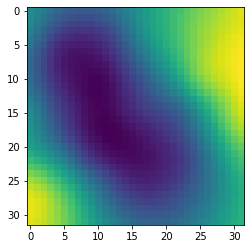

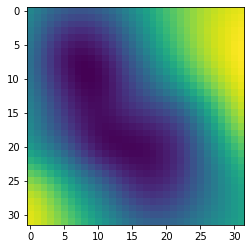

In [130]:
y_mean, y_std = gpr_model_ground_truth.predict(X, return_std=True)
y_mean = y_mean.reshape(32,32)
plt.imshow(u_opflow.clone().detach().cpu().squeeze())
plt.figure()
plt.imshow(y_mean)

### SGLD sampling

In [35]:
import sys
sys.path.insert(0, '../')

from imp import reload

import sampling_SGLD
import sampling_SGLD.samplers
import sampling_SGLD.SGLD
reload(sampling_SGLD.SGLD)
reload(sampling_SGLD.samplers)

from sampling_SGLD.samplers import LangevinDynamics

import copy
from tqdm import tqdm

## Regression on $\mathcal{A}$ Gaussian space

In [131]:
def nl_pdf_a(a, noise_level=noise_level):
    # return negative loglikehood
    u_from_a = G.inverse(a)
    loss1 = -0.5*torch.sum((u_obs_part - u_from_a[:,pos_mask,:])**2)/noise_level
    
    _, log_pa, log_det = G(u_from_a) 
    loss2 = log_pa + log_det
    
    loss = -(loss1 + loss2) 
    return loss

In [132]:
a_opflow_copy = reg_opflow_a.a_target.data.cpu().detach().clone()
u_opflow_copy = reg_opflow_a.target_u().cpu().detach().clone()

In [145]:

## initialize with the MAP result
x = torch.zeros_like(a_opflow_copy, requires_grad=True)
x.data = a_opflow_copy.to(device)
#x = nn.Parameter(u_opflow_copy, requires_grad=True).to(device)
#x = torch.zeros([2], requires_grad=True, device=device)

temperature = 1.0

max_itr = int(2e4)

# only designed for function SGLD
langevin_dynamics = LangevinDynamics(x,
                                     nl_pdf_a,
                                     lr=5e-3,
                                     lr_final=4e-3,
                                     max_itr=max_itr,
                                     device=device,
                                     base_dist = base_dist,
                                     temperature = temperature,
                                     )

hist_samples = []
loss_log = []
for j in tqdm(range(max_itr)):
    est, loss = langevin_dynamics.sample(epoch=j)
    loss_log.append(loss)
    if j % 10 == 0:
        hist_samples.append(est.cpu().numpy())

update
Tempertaure:1.0
start, white noise on A


100%|█████████████████████████████████████████████████████████████████████████████| 20000/20000 [51:36<00:00,  6.46it/s]


In [146]:
with torch.no_grad():
    a_samples_all = torch.Tensor(np.vstack(hist_samples)).to(device)
    u_samples_all = G.inverse(a_samples_all)

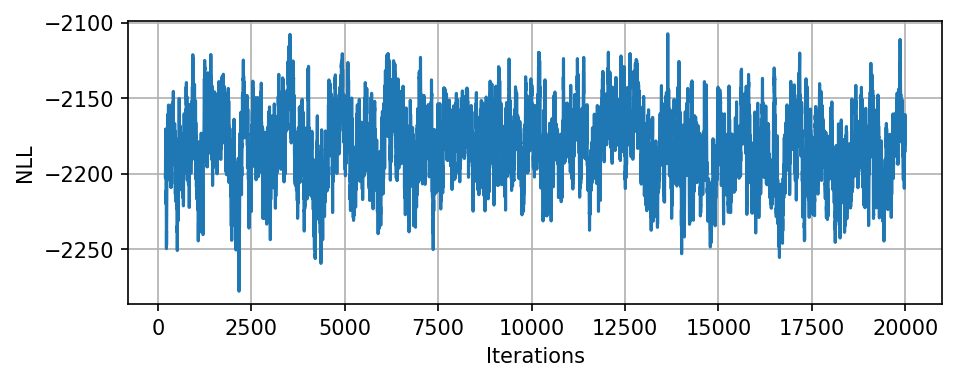

In [147]:
fig = plt.figure("training logs - net", dpi=150, figsize=(7, 2.5))
plt.plot(np.arange(200, len(loss_log)),loss_log[200:])
#plt.title("Unnormalized PDF")
plt.xlabel("Iterations")
plt.ylabel('NLL')
#plt.ylabel(r"$- \log \ \mathrm{N}(\mathbf{x} | \mu, \Sigma) + const.$")
plt.grid()

In [148]:
## calculate the mean predicted from OpFlow and Ground Truht 
est_samples = u_samples_all.detach().cpu().numpy()
est_samples = est_samples[20:]

sample_mean = np.mean(est_samples, axis=0).squeeze()
sample_std = np.std(est_samples, axis=0).squeeze()

### Final Plots

In [16]:

opflow_mean = sample_mean
opflow_std = sample_std

x = np.linspace(0, 1, ndim)
y = np.linspace(0, 1, ndim)
XX, YY = np.meshgrid(x, y)
XX = XX.reshape(-1, 1)
YY = YY.reshape(-1, 1)
X = np.concatenate([XX, YY], axis=1)
print(X.shape)
kernel = 1.0 * Matern(length_scale=length_scale_x, length_scale_bounds='fixed', nu=nu_x)
gpr_model_ground_truth = GaussianProcessRegressor(kernel=kernel, alpha=noise_level)

x_obs = X[pos_mask.reshape(-1)]
y_obs = u_obs_part.squeeze().detach().cpu().numpy()
gpr_model_ground_truth = gpr_model_ground_truth.fit(x_obs, y_obs) #update the GP model

(1024, 2)


In [17]:
saved_folder = 'GRF2GRF_set1_lr_1e_3_reg'
if not os.path.exists(f"Regression_results/{saved_folder}"):
    os.makedirs(f"Regression_results/{saved_folder}")

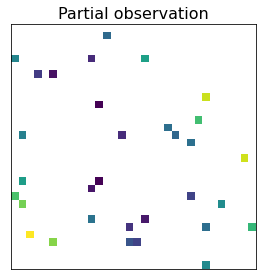

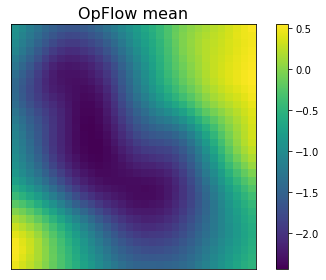

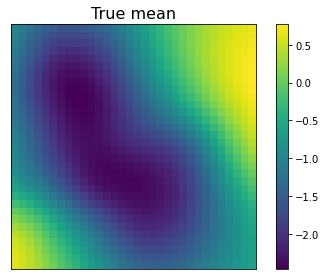

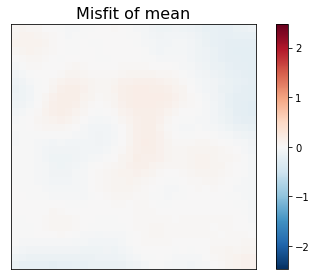

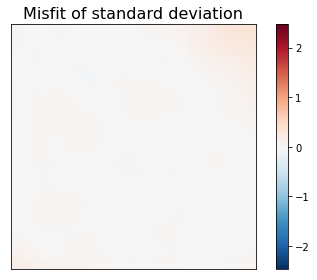

In [21]:
y_mean, y_std = gpr_model_ground_truth.predict(X, return_std=True)
y_mean = y_mean.reshape(32,32)
y_std = y_std.reshape(32,32)
y_samples = gpr_model_ground_truth.sample_y(X, 5000).reshape(32,32,-1)

part_gt = u_obs_full.clone()
part_gt[~pos_mask] = np.nan
# plot the partial observation 
plt.imshow(part_gt)
plt.xticks([])
plt.yticks([])
plt.title('Partial observation', fontsize=16)
plt.tight_layout()
#plt.savefig(f"paper_pdf/{folder}/ex2_partial_obs.pdf")
#plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex2_partial_obs.pdf")

plt.figure()
plt.imshow(sample_mean)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('OpFlow mean', fontsize=16)
plt.tight_layout()
#plt.savefig(f"paper_pdf/{folder}/ex2_opflow_mean.pdf")
#plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex2_opflow_mean.pdf")

plt.figure()
plt.imshow(y_mean)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('True mean', fontsize=16)
plt.tight_layout()
#plt.savefig(f"paper_pdf/{folder}/ex2_true_mean.pdf")
#plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex2_true_mean.pdf")

plt.figure()
relative_error = (sample_mean - y_mean)
norm = TwoSlopeNorm(vmin= y_mean.min(), vmax= -y_mean.min(),vcenter=0)
#plt.imshow(relative_error, vmin= y_mean.min(), vmax= y_mean.max())
plt.imshow(relative_error, norm=norm,cmap="RdBu_r")
#pc = plt.pcolormesh(x,y,z, norm=norm, cmap="RdBu_r")
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Misfit of mean', fontsize=16)
plt.tight_layout()
plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex2_misfit_mean.pdf")

plt.figure()
relative_error = (sample_mean - y_mean)
norm = TwoSlopeNorm(vmin= y_mean.min(), vmax= -y_mean.min(),vcenter=0)
#plt.imshow(relative_error, vmin= y_mean.min(), vmax= y_mean.max())
plt.imshow(y_std-opflow_std, norm=norm, cmap="RdBu_r")
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Misfit of standard deviation', fontsize=16)
plt.tight_layout()
plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex2_misfit_std.pdf")

### 

### Generate 3 representative scenarios

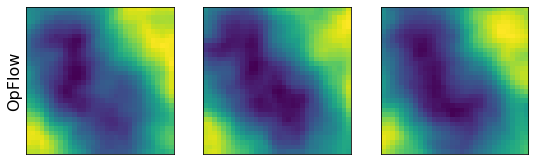

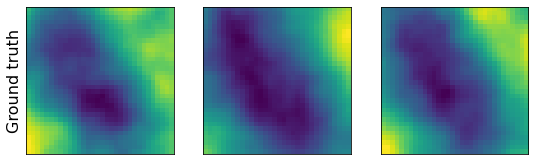

In [183]:
## each one generate 3 plots
## For the scenario, select 3 representative scenarios for OpFlow and Ground Truth

#random_idx = np.array([280, 73, 401]) #used for the paper
#random_idx_gt = np.array([25, 7,380]) #used for the paper
random_idx = np.random.choice(len(est_samples), 3, replace=False)
fig, ax = plt.subplots(1,3, figsize=(9,3))    
for i in range(3):
    x_opflow = est_samples[random_idx[i]].squeeze()
    ax[i].imshow(x_opflow)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    if i == 0:
        ax[i].set_ylabel('OpFlow', fontsize=16)
        
plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex2_scen_opflow.pdf")        

        
random_idx_gt = np.random.choice(len(y_samples), 3, replace=False)
fig, ax = plt.subplots(1,3, figsize=(9,3))    
for i in range(3):
    y_example = y_samples[:,:,random_idx_gt[i]].squeeze()
    ax[i].imshow(y_example)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    if i == 0:
        ax[i].set_ylabel('Ground truth', fontsize=16)
plt.savefig(f"Regression_results/{saved_folder}/GRF_reg_ex2_scen_gt.pdf")   

In [181]:
import h5py
f = h5py.File(f"Regression_results/{saved_folder}.h5py", "w")
f.create_dataset('u_full_obs', data=u_obs_full.numpy())
f.create_dataset('x_obs_idx', data=mask_idx)
f.create_dataset('a_opflow_map', data=a_opflow_copy.squeeze().numpy())
f.create_dataset('sample_from_opflow', data=u_samples_all.detach().cpu().numpy())
f.close()